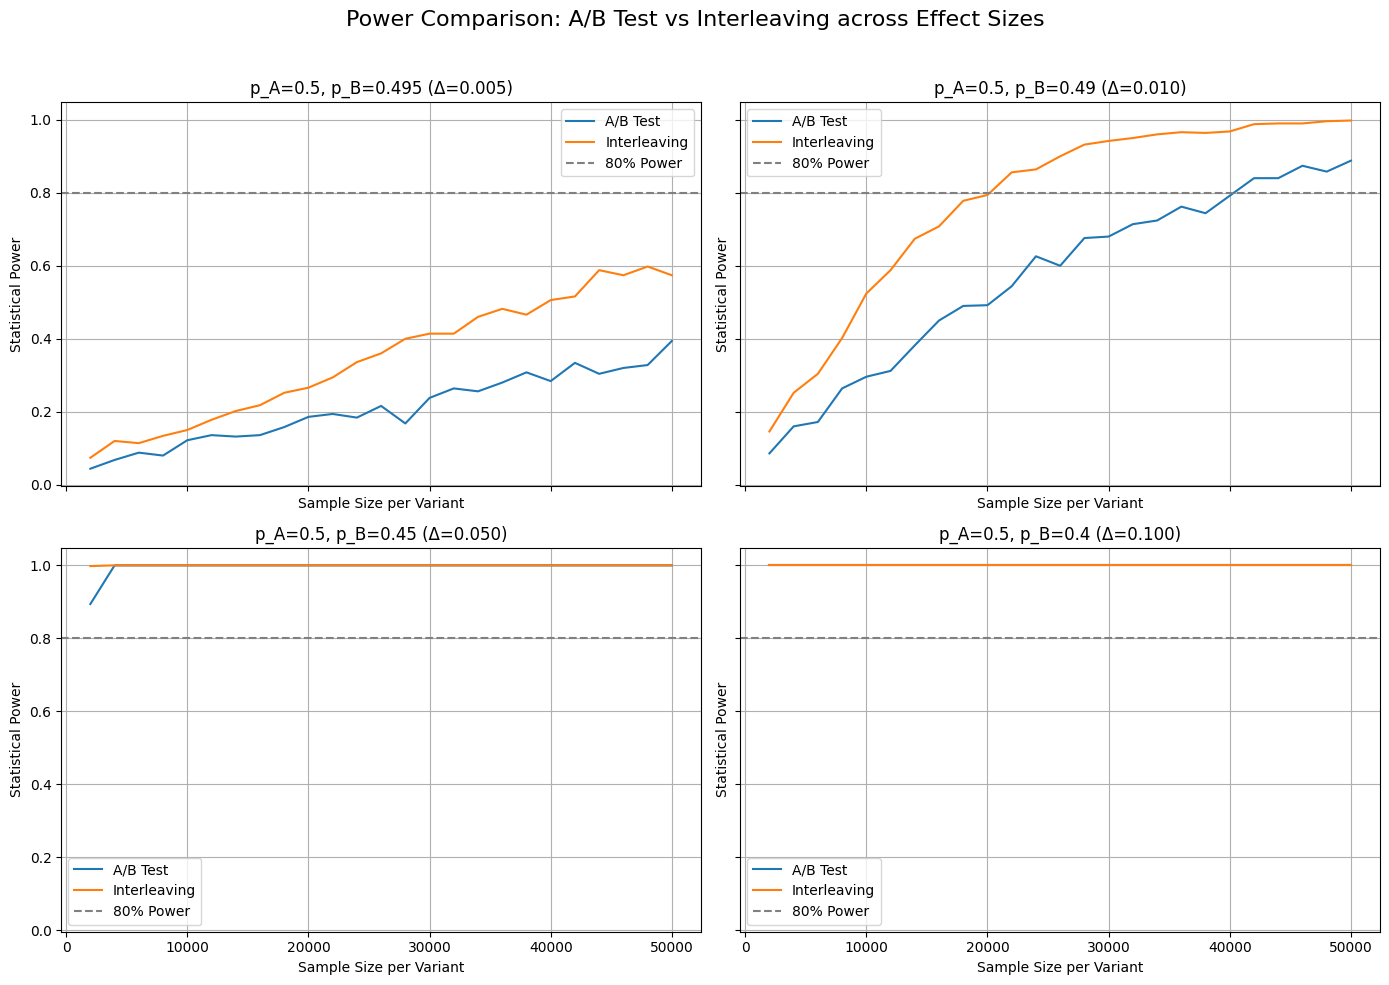

In [ ]:
#Part 1: Basic Power Comparison — A/B Test vs Interleaving
import numpy as np
from scipy.stats import ttest_rel, binomtest
import matplotlib.pyplot as plt

# Simulation parameters
np.random.seed(42)

alpha = 0.05  # Significance level
power_target = 0.8  # 80% power
max_samples = 50000  # ✅ Increased max sample size!
step = 2000  # ✅ Slightly larger step size to reduce runtime
n_simulations = 500  # Number of simulations per sample size

# Effect size scenarios to test
effect_sizes = [
    (0.50, 0.495),  # 1% diff
    (0.50, 0.49),   # 2% diff
    (0.50, 0.45),   # 5% diff
    (0.50, 0.40),   # 10% diff
]

sample_sizes = np.arange(step, max_samples + 1, step)

fig, axs = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)
axs = axs.flatten()

for idx, (p_A, p_B) in enumerate(effect_sizes):
    powers_ab = []
    powers_interleaving = []

    def simulate_ab_test(n):
        clicks_A = np.random.binomial(1, p_A, n)
        clicks_B = np.random.binomial(1, p_B, n)
        _, p_value = ttest_rel(clicks_A, clicks_B)
        return p_value

    def simulate_interleaving(n):
        # Each user sees A and B interleaved
        results = []
        for _ in range(n):
            click_A = np.random.binomial(1, p_A)
            click_B = np.random.binomial(1, p_B)
            results.append(click_A - click_B)
        results = np.array(results)
        # Paired t-test because interleaving uses within-user comparison
        t_stat, p_value = ttest_rel(results, np.zeros_like(results))
        return p_value

    for n in sample_sizes:
        # print(n)
        significant_ab = 0
        significant_interleaving = 0
        for _ in range(n_simulations):
            if simulate_ab_test(n) < alpha:
                significant_ab += 1
            if simulate_interleaving(2 * n) < alpha:
                significant_interleaving += 1
        powers_ab.append(significant_ab / n_simulations)
        powers_interleaving.append(significant_interleaving / n_simulations)

    # Plotting
    ax = axs[idx]
    ax.plot(sample_sizes, powers_ab, label='A/B Test')
    ax.plot(sample_sizes, powers_interleaving, label='Interleaving')
    ax.axhline(power_target, color='gray', linestyle='--', label='80% Power')
    ax.set_title(f"p_A={p_A}, p_B={p_B} (Δ={abs(p_A - p_B):.3f})")
    ax.set_xlabel("Sample Size per Variant")
    ax.set_ylabel("Statistical Power")
    ax.legend()
    ax.grid(True)

plt.suptitle("Power Comparison: A/B Test vs Interleaving across Effect Sizes", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Variance of A/B Test differences: 0.002394762474328793
Variance of Interleaving differences: 0.00039756812776619676


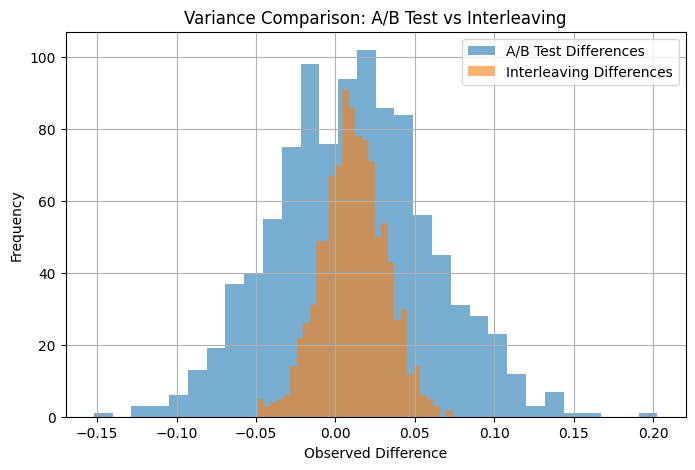

In [13]:
# Simple variance demonstration
np.random.seed(42)

# A/B test - Unpaired differences (higher variance)
ab_diffs = np.random.normal(loc=0.01, scale=0.05, size=1000)

# Interleaving - Paired differences (lower variance)
interleaving_diffs = np.random.normal(loc=0.01, scale=0.02, size=1000)

print("Variance of A/B Test differences:", np.var(ab_diffs))
print("Variance of Interleaving differences:", np.var(interleaving_diffs))

# Optional: Plot distributions
plt.figure(figsize=(8, 5))
plt.hist(ab_diffs, bins=30, alpha=0.6, label='A/B Test Differences')
plt.hist(interleaving_diffs, bins=30, alpha=0.6, label='Interleaving Differences')
plt.legend()
plt.title('Variance Comparison: A/B Test vs Interleaving')
plt.xlabel('Observed Difference')
plt.ylabel('Frequency')
plt.grid()
plt.show()

In [20]:
import numpy as np
import pandas as pd
import random

# Simulated ranked results from two algorithms
ranker_A = ['A1', 'A2', 'A3', 'A4', 'A5']
ranker_B = ['B1', 'B2', 'A2', 'A4', 'B5']  # includes overlaps

# Simulated scores for probabilistic interleaving
scores_A = [0.9, 0.8, 0.7, 0.6, 0.5]
scores_B = [0.85, 0.75, 0.65, 0.55, 0.45]

# Balanced Interleaving
def balanced_interleave(A, B):
    result = []
    seen = set()
    for i in range(len(A)):
        if A[i] not in seen:
            result.append(A[i])
            seen.add(A[i])
        if i < len(B) and B[i] not in seen:
            result.append(B[i])
            seen.add(B[i])
    return result

# Team Draft Interleaving + Attribution
def team_draft_interleave(A, B):
    result = []
    attribution = []  # Track which ranker contributed which item
    seen = set()
    i, j = 0, 0
    turn = random.choice(['A', 'B'])
    while len(result) < len(A) + len(B):
        if turn == 'A' and i < len(A):
            if A[i] not in seen:
                result.append(A[i])
                attribution.append('A')
                seen.add(A[i])
            i += 1
            turn = 'B'
        elif turn == 'B' and j < len(B):
            if B[j] not in seen:
                result.append(B[j])
                attribution.append('B')
                seen.add(B[j])
            j += 1
            turn = 'A'
        if i >= len(A) and j >= len(B):
            break
    return result, attribution

# Probabilistic Interleaving
def probabilistic_interleave(A, B, scores_A, scores_B):
    result = []
    seen = set()
    i, j = 0, 0
    while len(result) < len(A) + len(B):
        if i < len(A) and j < len(B):
            prob_A = scores_A[i] / (scores_A[i] + scores_B[j])
            if random.random() < prob_A and A[i] not in seen:
                result.append(A[i])
                seen.add(A[i])
                i += 1
            elif B[j] not in seen:
                result.append(B[j])
                seen.add(B[j])
                j += 1
        elif i < len(A) and A[i] not in seen:
            result.append(A[i])
            seen.add(A[i])
            i += 1
        elif j < len(B) and B[j] not in seen:
            result.append(B[j])
            seen.add(B[j])
            j += 1
        else:
            break
    return result

# Run interleaving strategies
balanced = balanced_interleave(ranker_A, ranker_B)
team_draft, attribution = team_draft_interleave(ranker_A, ranker_B)
probabilistic = probabilistic_interleave(ranker_A, ranker_B, scores_A, scores_B)

# Display results
interleaved_df = pd.DataFrame({
    'Balanced Interleaving': pd.Series(balanced),
    'Team Draft Interleaving': pd.Series(team_draft),
    'Probabilistic Interleaving': pd.Series(probabilistic)
})

print("Interleaving Algorithm Outputs:")
print(interleaved_df.to_string(index=False))


Interleaving Algorithm Outputs:
Balanced Interleaving Team Draft Interleaving Probabilistic Interleaving
                   A1                      A1                         A1
                   B1                      B1                         A2
                   A2                      A2                         A3
                   B2                      B2                         B1
                   A3                      A3                         B2
                   A4                      A4                         A4
                   A5                      A5                         A5
                   B5                      B5                        NaN


0.5790233165524401


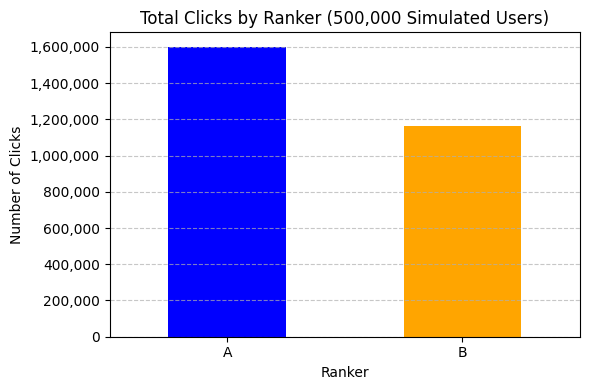

In [33]:
# Re-run everything since the code state was reset

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

# Simulated ranked results from two algorithms
ranker_A = ['A1', 'A2', 'A3', 'A4', 'A5']
ranker_B = ['B1', 'B2', 'A2', 'A4', 'B5']

# Relevance scores (used for determining click probability)
scores_A = {'A1': 0.9, 'A2': 0.8, 'A3': 0.7, 'A4': 0.6, 'A5': 0.5}
scores_B = {'B1': 0.85, 'B2': 0.75, 'A2': 0.65, 'A4': 0.55, 'B5': 0.45}

# Team Draft Interleaving function
def team_draft_interleave(A, B):
    result = []
    seen = set()
    i, j = 0, 0
    turn = random.choice(['A', 'B'])
    while len(result) < len(A) + len(B):
        if turn == 'A' and i < len(A):
            if A[i] not in seen:
                result.append(('A', A[i]))
                seen.add(A[i])
            i += 1
            turn = 'B'
        elif turn == 'B' and j < len(B):
            if B[j] not in seen:
                result.append(('B', B[j]))
                seen.add(B[j])
            j += 1
            turn = 'A'
        if i >= len(A) and j >= len(B):
            break
    return result

# Simulate 10,000 user sessions
n_users = 500000
click_data = []

for user_id in range(n_users):
    interleaved_list = team_draft_interleave(ranker_A, ranker_B)
    for model, item in interleaved_list:
        if model == 'A':
            p_click = scores_A.get(item, 0.5)
        else:
            p_click = scores_B.get(item, 0.5)
        click = np.random.binomial(1, p_click)
        click_data.append({'User': user_id, 'Ranker': model, 'Item': item, 'Click': click})

# Convert to DataFrame
clicks_df = pd.DataFrame(click_data)

# Aggregate click counts
clicks_A = clicks_df[(clicks_df['Ranker'] == 'A') & (clicks_df['Click'] == 1)].shape[0]
clicks_B = clicks_df[(clicks_df['Ranker'] == 'B') & (clicks_df['Click'] == 1)].shape[0]

# Compute Preference Win Rate for Ranker A
preference_win_rate_A = clicks_A / (clicks_A + clicks_B) if (clicks_A + clicks_B) > 0 else np.nan

print(preference_win_rate_A)


# Reuse the clicks_df from the simulation
# Add Ranker-wise click counts
click_counts = clicks_df[clicks_df['Click'] == 1]['Ranker'].value_counts().sort_index()

# Plot
plt.figure(figsize=(6, 4))
click_counts.plot(kind='bar', color=['blue', 'orange'])

plt.title("Total Clicks by Ranker (500,000 Simulated Users)")
plt.xlabel("Ranker")
plt.ylabel("Number of Clicks")
plt.xticks(rotation=0)

# Fix the y-axis to use commas instead of scientific notation
ax = plt.gca()
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()